In [1]:
# Importing 
%load_ext autoreload
%autoreload 2
import os 
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer

# Finding the root directory 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import src.utils.file_utils as fu 
import src.helpers.feature_engineering_helper as feh

cfg_schema = fu.load_config("schema")
cfg_feature_engineering = fu.load_config("feature_engineering")["feature_engineering"]

In [2]:
# Reading the Processed data set 
df = fu.load_parquet("hmda_2024_model")

Loading dataset from C:\Users\emmah\6341_Project\data\processed\hmda_2024_model.parquet


In [3]:
# Loading the scaler and scaling the numerical values
numeric_cols = ['loan_amount', 'income', 'combined_loan_to_value_ratio', 'loan_term', 'intro_rate_period', 'prepayment_penalty_term', 
                'property_value']
scaler = joblib.load(os.path.join(project_root, 'models', 'scaler.pkl'))
df_scaled = scaler.transform(df[numeric_cols])
scaled_df = pd.DataFrame(df_scaled, columns=numeric_cols)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
scaled_df_imp = imputer.fit_transform(scaled_df)
df_numerical = pd.DataFrame(scaled_df_imp, columns = numeric_cols)

In [4]:
# Loading the OHE variables
ohe_cols = [col for col in df.columns
           if col not in numeric_cols and df[col].nunique() <= 2]
df_ohe = df[ohe_cols]
cluster_df = pd.concat([df_numerical, df_ohe], axis = 1)

In [5]:
# Minibatch K-Means
sample_df = cluster_df.sample(n=250000, random_state = 42)

k_range = range(2,15)
elbow_scores = []
for k in k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =50000, random_state = 42)
    mbk.fit(sample_df)
    elbow_scores.append(mbk.inertia_)

In [28]:
# Minibatch Silhouette Scores 
sample_df = cluster_df.sample(n=85000, random_state = 42)
sil_scores = []
sil_k_range = range(2,15)
for k in sil_k_range:
    mbk = MiniBatchKMeans(n_clusters = k, batch_size =20000, random_state = 42)
    mbk.fit(sample_df)
    sil_scores.append(silhouette_score(sample_df, mbk.labels_))

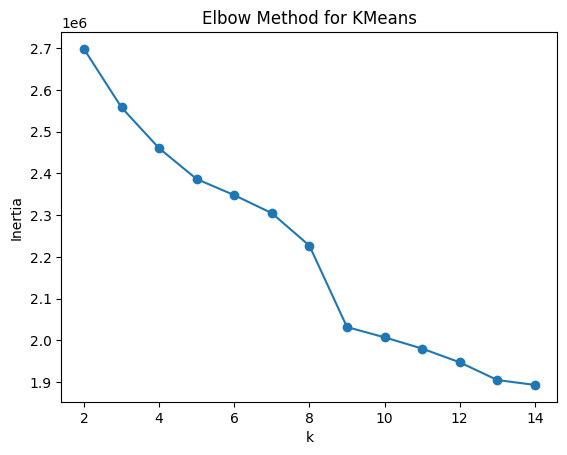

In [6]:
# Plotting Elbow Method 
plt.plot(k_range, elbow_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for KMeans")

Text(0.5, 1.0, 'Silhouette Scores vs k')

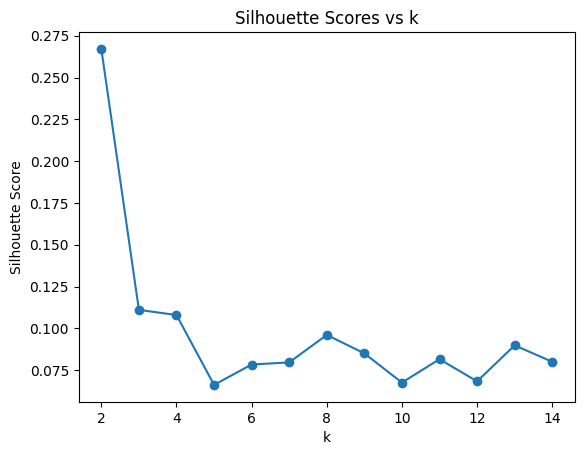

In [29]:
# Plotting Silhouette Method
plt.plot(sil_k_range, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs k")

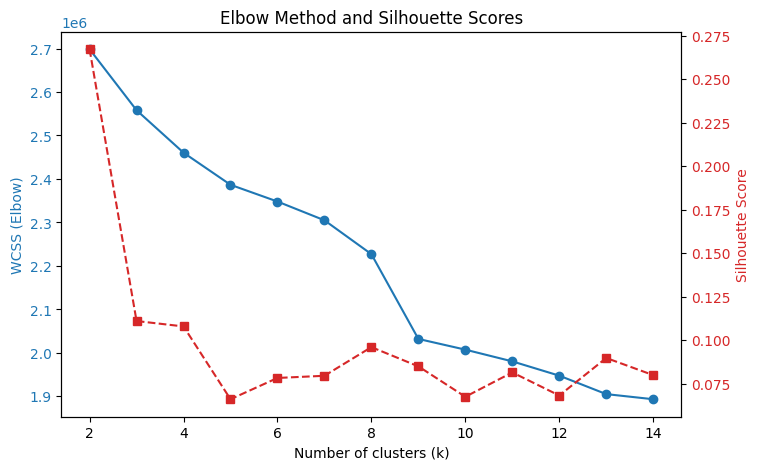

In [30]:
fig, ax1 = plt.subplots(figsize = (8,5))
color1 = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('WCSS (Elbow)', color=color1)
ax1.plot(k_range, elbow_scores, marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# Create a second y-axis for silhouette scores
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(sil_k_range, sil_scores, marker='s', linestyle='--', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
plt.title('Elbow Method and Silhouette Scores')

# Saving plot
elbow_sil_plot_path = os.path.join(project_root, 'reports','figures', 'elbow_silhouette_plot.png')
os.makedirs(os.path.dirname(elbow_sil_plot_path), exist_ok=True)
plt.savefig(elbow_sil_plot_path, dpi=300, bbox_inches='tight')

In [ ]:
# Based on the above plot we chose a k of 8 because it balances the two models. 

In [31]:
# Training it on the entire dataset
k = 8
batch_size = 50000

mbk = MiniBatchKMeans(n_clusters = k, batch_size = batch_size, random_state=42)
cluster_df = cluster_df.astype(np.float32)

n_rows = cluster_df.shape[0]
for start in range(0, n_rows, batch_size):
    end = min(start + batch_size, n_rows)
    mbk.partial_fit(cluster_df[start:end])

cluster_ids = np.zeros(len(cluster_df), dtype=np.int32)
for start in range(0,len(cluster_df), batch_size):
    end = start + batch_size
    batch = cluster_df.iloc[start:end].astype(np.float32)
    cluster_ids[start:end] = mbk.predict(batch)
    
df['cluster_id'] = cluster_ids


In [33]:
# Saving the data Parquet 
cluster_parquet_path = os.path.join(project_root, 'data','processed', 'hmda_2024_model_with_clusters.parquet')
os.makedirs(os.path.dirname(cluster_parquet_path), exist_ok=True)
df.to_parquet(cluster_parquet_path, index=False)

In [34]:
#Cluster Summary Table 
cluster_summary = df.groupby('cluster_id').agg({
    'loan_amount' : ['mean', 'std'],
    'income' : ['mean', 'std'],
    'combined_loan_to_value_ratio' : ['mean', 'std'],
    'loan_term': ['mean', 'std'],
    'intro_rate_period': ['mean', 'std'],
    'prepayment_penalty_term': ['mean',  'std'], 
    'property_value': ['mean', 'std']})

cluster_summary.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col 
                           for col in cluster_summary.columns]
cluster_summary = cluster_summary.reset_index()
cluster_summary = cluster_summary.round(4)

ohe_cols = [col for col in df.columns
           if col not in numeric_cols and df[col].nunique() <= 2]
cluster_proportions = df.groupby('cluster_id')[ohe_cols].mean().reset_index()
cluster_proportions = cluster_proportions.round(4)

cluster_summary = cluster_summary.merge(cluster_proportions, on='cluster_id', how='left')

# Saving CSV File
cluster_csv_path = os.path.join(project_root, 'reports','tables', 'cluster_summary.csv')
os.makedirs(os.path.dirname(cluster_csv_path), exist_ok=True)
cluster_summary.to_csv(cluster_csv_path, index=False)
    

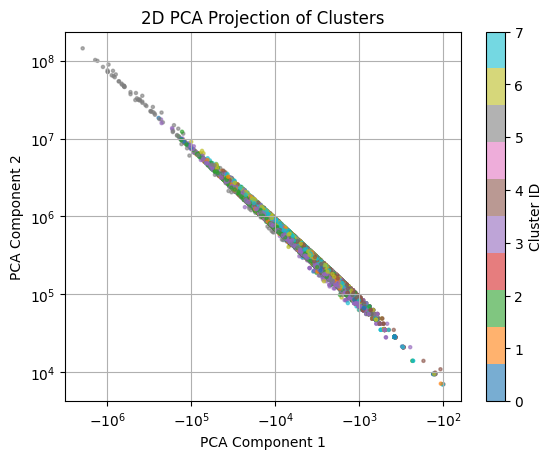

In [35]:
# Cluster PCA Plot
sample_df = df.sample(n=50_000, random_state=42)
pca_features = list(cluster_df.columns)
sample_features = sample_df[pca_features]

pca = joblib.load(os.path.join(project_root, 'models', 'ipca.pkl'))
pca_data = pca.transform(sample_features)
pca_2d = pca_data[:,:2]

plt.scatter(pca_2d[:,0], pca_2d[:,1], c = sample_df['cluster_id'], cmap = 'tab10', s = 5, alpha = 0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.xscale('symlog')
plt.yscale('symlog')
plt.title("2D PCA Projection of Clusters")
plt.colorbar(label='Cluster ID')
plt.grid(True)